In [57]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [58]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [59]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [60]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [61]:
tf.keras.backend.clear_session()

In [62]:
subject = 'Mato Grosso - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [63]:
data = pd.read_csv('2003_mo_model_input_MT.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Mato Grosso - Produção de Cimento (t),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Mato Grosso - Consumo de Cimento (t),Mato Grosso - Desemprego,Mato Grosso - IDH,Mato Grosso - PIB - Estadual,Mato Grosso - PIB - Construção Civil,Mato Grosso - PIB - Per Capita,Mato Grosso - PIB - Preços de Mercado,Mato Grosso - value
0,2003-1,50.917240,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,47.470,8.297178,0.745147,6.084564e+07,2.670588e+06,16.831332,5.118946e+07,0.331800
1,2003-2,50.851586,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,45.387,8.291317,0.745308,6.092768e+07,2.672688e+06,16.835967,5.121614e+07,0.333615
2,2003-3,50.970549,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,44.907,8.285457,0.745469,6.100973e+07,2.674788e+06,16.840602,5.124282e+07,0.334864
3,2003-4,51.049978,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,45.467,8.279596,0.745630,6.109177e+07,2.676888e+06,16.845237,5.126950e+07,0.336048
4,2003-5,51.567529,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,56.246,8.273735,0.745791,6.117381e+07,2.678988e+06,16.849872,5.129619e+07,0.336447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,119.544326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.533,NaN,NaN,NaN,NaN,NaN,NaN,0.600607
236,2022-9,118.223448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,183.895,NaN,NaN,NaN,NaN,NaN,NaN,0.598965
237,2022-10,117.524152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.525,NaN,NaN,NaN,NaN,NaN,NaN,0.596866
238,2022-11,116.430559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,161.683,NaN,NaN,NaN,NaN,NaN,NaN,0.594246


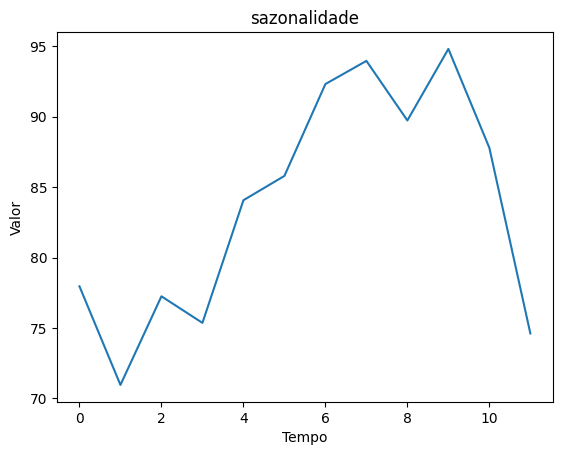

,sazonalidade
sazonalidade,
0,77.959321
1,70.958929
2,77.249607
3,75.363929
4,84.070286
5,85.798357
6,92.318929
7,93.964643
8,89.735357


In [64]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [65]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Mato Grosso - Produção de Cimento (t),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Mato Grosso - Desemprego,Mato Grosso - IDH,Mato Grosso - PIB - Estadual,Mato Grosso - PIB - Construção Civil,Mato Grosso - PIB - Per Capita,Mato Grosso - PIB - Preços de Mercado,Mato Grosso - value,sazonalidade,Mato Grosso - Consumo de Cimento (t)
0,2003-1,50.917240,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,8.297178,0.745147,6.084564e+07,2.670588e+06,16.831332,5.118946e+07,0.331800,77.959321,47.470
1,2003-2,50.851586,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,8.291317,0.745308,6.092768e+07,2.672688e+06,16.835967,5.121614e+07,0.333615,70.958929,45.387
2,2003-3,50.970549,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,8.285457,0.745469,6.100973e+07,2.674788e+06,16.840602,5.124282e+07,0.334864,77.249607,44.907
3,2003-4,51.049978,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,8.279596,0.745630,6.109177e+07,2.676888e+06,16.845237,5.126950e+07,0.336048,75.363929,45.467
4,2003-5,51.567529,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,8.273735,0.745791,6.117381e+07,2.678988e+06,16.849872,5.129619e+07,0.336447,84.070286,56.246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,119.544326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.600607,93.964643,192.533
236,2022-9,118.223448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.598965,89.735357,183.895
237,2022-10,117.524152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.596866,94.814000,180.525
238,2022-11,116.430559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.594246,87.790500,161.683


In [66]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      55.998
1      49.346
2      57.277
3      61.881
4      65.040
        ...  
235       NaN
236       NaN
237       NaN
238       NaN
239       NaN
Name: Mato Grosso - Consumo de Cimento (t), Length: 240, dtype: float64

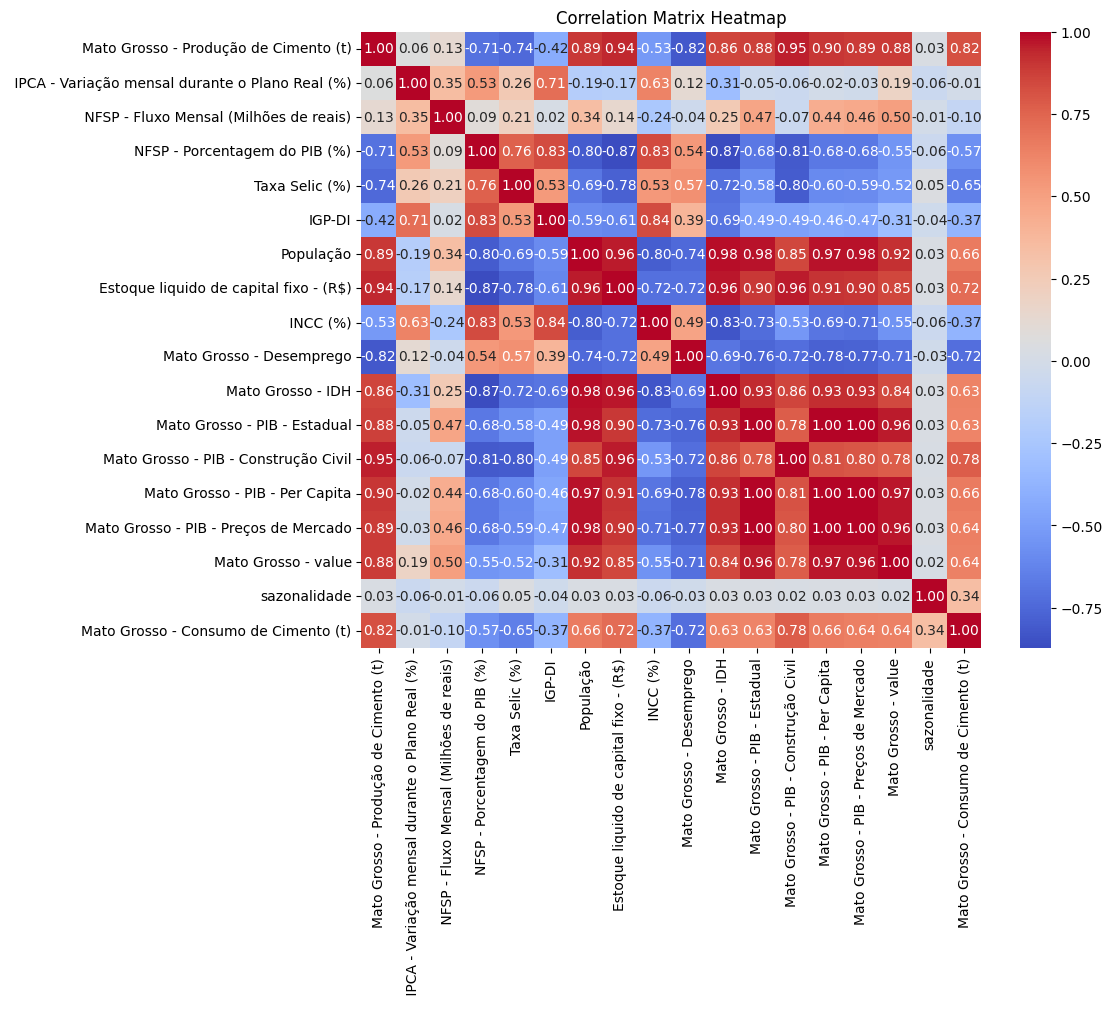

In [67]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [68]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [69]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Mato Grosso - Produção de Cimento (t),1.875153e+03
1,IPCA - Variação mensal durante o Plano Real (%),2.922738e+03
2,NFSP - Fluxo Mensal (Milhões de reais),3.363879e+02
3,NFSP - Porcentagem do PIB (%),5.224699e+02
4,Taxa Selic (%),5.862574e+01
5,IGP-DI,3.436441e+02
6,População,1.795343e+06
7,Estoque liquido de capital fixo - (R$),1.100262e+07
8,INCC (%),1.148087e+03
9,Mato Grosso - Desemprego,3.924509e+03


In [70]:
data = remove_high_vif_columns(safe_data, 10000000)
data

Num columns removed: 1


,Mato Grosso - Produção de Cimento (t),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Mato Grosso - Desemprego,Mato Grosso - IDH,Mato Grosso - PIB - Estadual,Mato Grosso - PIB - Construção Civil,Mato Grosso - PIB - Per Capita,Mato Grosso - value,sazonalidade
0,50.917240,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,8.297178,0.745147,6.084564e+07,2.670588e+06,16.831332,0.331800,77.959321
1,50.851586,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,8.291317,0.745308,6.092768e+07,2.672688e+06,16.835967,0.333615,70.958929
2,50.970549,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,8.285457,0.745469,6.100973e+07,2.674788e+06,16.840602,0.334864,77.249607
3,51.049978,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,8.279596,0.745630,6.109177e+07,2.676888e+06,16.845237,0.336048,75.363929
4,51.567529,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,8.273735,0.745791,6.117381e+07,2.678988e+06,16.849872,0.336447,84.070286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,93.020506,0.366904,-5783.316460,2.206994,0.545067,0.471521,1.987710e+08,7.783063e+06,0.378150,7.168497,0.757203,7.669273e+07,2.825171e+06,17.851260,0.425999,93.964643
176,93.279675,0.358935,-6001.730740,2.215328,0.782910,0.476827,1.988450e+08,7.780841e+06,0.377666,7.156691,0.757111,7.670730e+07,2.825002e+06,17.852668,0.425595,89.735357
177,93.542939,0.354313,-6454.887704,2.232466,0.909682,0.475427,1.989190e+08,7.778619e+06,0.377838,7.144884,0.757019,7.672188e+07,2.824833e+06,17.854077,0.425196,94.814000
178,93.692873,0.352728,-6243.191421,2.263185,1.050614,0.491301,1.989930e+08,7.776397e+06,0.370057,7.133078,0.756927,7.673645e+07,2.824663e+06,17.855485,0.424799,87.790500


In [71]:
input_data = data.iloc[:split_index + 1,1:-1]
# mean = np.mean(input_data, axis=0)
# stddev =  np.std(input_data, axis=0)
# input_data = ((input_data - mean) /stddev)
scaler=MinMaxScaler()
scaled_data = scaler.fit_transform(input_data)
input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Mato Grosso - Desemprego,Mato Grosso - IDH,Mato Grosso - PIB - Estadual,Mato Grosso - PIB - Construção Civil,Mato Grosso - PIB - Per Capita,Mato Grosso - value
0,1.000000,0.543630,1.000000,0.741706,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.182887
1,0.909144,0.544990,0.965719,0.573104,0.936603,0.008302,0.011007,0.968765,0.996341,0.011805,0.005158,0.008692,0.004519,0.195974
2,0.853620,0.532585,0.927412,0.925680,0.906543,0.016605,0.022015,0.948151,0.992682,0.023609,0.010316,0.017385,0.009039,0.204977
3,0.828878,0.504220,0.885588,0.542253,0.858675,0.024907,0.033022,0.928398,0.989023,0.035414,0.015474,0.026077,0.013558,0.213516
4,0.796137,0.515509,0.838034,0.803992,0.824839,0.033209,0.044030,0.970256,0.985364,0.047219,0.020632,0.034770,0.018077,0.216392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.038179,0.496222,0.033352,0.034086,0.168620,0.986456,0.889786,0.020697,0.295362,0.884534,0.996335,0.639854,0.994506,0.862138
176,0.016717,0.473326,0.034217,0.187836,0.176428,0.989842,0.885419,0.019895,0.287991,0.877780,0.997252,0.639154,0.995879,0.859221
177,0.004270,0.425824,0.035996,0.269786,0.174368,0.993228,0.881053,0.020180,0.280620,0.871025,0.998168,0.638453,0.997253,0.856343
178,0.000000,0.448015,0.039184,0.360889,0.197726,0.996614,0.876686,0.007298,0.273250,0.864271,0.999084,0.637753,0.998626,0.853480


In [72]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Mato Grosso - Desemprego,Mato Grosso - IDH,Mato Grosso - PIB - Estadual,Mato Grosso - PIB - Construção Civil,Mato Grosso - PIB - Per Capita,Mato Grosso - value
0,1.000000,0.543630,1.000000,0.741706,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.182887
1,0.909144,0.544990,0.965719,0.573104,0.936603,0.008302,0.011007,0.968765,0.996341,0.011805,0.005158,0.008692,0.004519,0.195974
2,0.853620,0.532585,0.927412,0.925680,0.906543,0.016605,0.022015,0.948151,0.992682,0.023609,0.010316,0.017385,0.009039,0.204977
3,0.828878,0.504220,0.885588,0.542253,0.858675,0.024907,0.033022,0.928398,0.989023,0.035414,0.015474,0.026077,0.013558,0.213516
4,0.796137,0.515509,0.838034,0.803992,0.824839,0.033209,0.044030,0.970256,0.985364,0.047219,0.020632,0.034770,0.018077,0.216392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.144755,0.772284,0.015040,0.428805,0.061396,0.945698,0.937006,0.094130,0.471747,0.960226,0.982655,0.664592,0.986060,0.896453
164,0.133956,0.741958,0.016631,0.394850,0.095565,0.949109,0.933675,0.087555,0.446789,0.954544,0.984109,0.660625,0.985826,0.888864
165,0.141095,0.686725,0.018850,0.402192,0.096417,0.952520,0.930344,0.083404,0.421831,0.948861,0.985562,0.656657,0.985592,0.886064
166,0.102393,0.792808,0.020846,0.428809,0.052056,0.955931,0.927013,0.075773,0.396873,0.943179,0.987015,0.652690,0.985359,0.883151


In [73]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       55.998
1       49.346
2       57.277
3       61.881
4       65.040
        ...   
163    142.145
164    121.124
165    130.503
166    104.115
167     90.690
Name: Mato Grosso - Consumo de Cimento (t), Length: 168, dtype: float64

In [74]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [75]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 14)

In [76]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Mato Grosso - Desemprego,Mato Grosso - IDH,Mato Grosso - PIB - Estadual,Mato Grosso - PIB - Construção Civil,Mato Grosso - PIB - Per Capita,Mato Grosso - value
132,0.710818,0.600233,0.076793,0.228507,0.297841,0.834889,1.000000,0.368307,0.499449,0.793003,0.858911,0.942059,0.910764,0.933339
133,0.737933,0.683286,0.080065,0.227972,0.310249,0.838610,0.999030,0.356043,0.517286,0.789924,0.864226,0.931628,0.913969,0.943904
134,0.731922,0.691333,0.083086,0.297136,0.298259,0.842332,0.998060,0.365871,0.535123,0.786844,0.869540,0.921198,0.917175,0.954516
135,0.722500,0.683763,0.085709,0.190626,0.264133,0.846053,0.997090,0.374560,0.552960,0.783765,0.874855,0.910768,0.920381,0.962942
136,0.735417,0.750790,0.089485,0.174875,0.283400,0.849774,0.996121,0.347016,0.570797,0.780685,0.880169,0.900338,0.923586,0.971342
137,0.736663,0.748426,0.091963,0.212105,0.345980,0.853496,0.995151,0.340984,0.588634,0.777606,0.885484,0.889908,0.926792,0.979716
138,0.750484,0.765274,0.093682,0.239148,0.355524,0.857217,0.994181,0.333970,0.606471,0.774526,0.890798,0.879478,0.929997,0.987771
139,0.781650,0.799973,0.094876,0.292080,0.388252,0.860938,0.993211,0.316991,0.624309,0.771447,0.896113,0.869047,0.933203,0.994292
140,0.780630,0.803815,0.095765,0.237576,0.392252,0.864660,0.992241,0.324046,0.642146,0.768367,0.901427,0.858617,0.936408,0.997216
141,0.771685,0.692895,0.095412,0.297638,0.401389,0.868381,0.991271,0.324890,0.659983,0.765287,0.906741,0.848187,0.939614,1.000000


In [77]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 14)

In [78]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [79]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [80]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][20:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [81]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[3409310361, 2802553540, 4214070845, 4243684626, 3804326538, 3964255963, 3648781710, 2694020105, 4105285547, 1538426971]


Step: 0 ___________________________________________
val_loss: 234.8901824951172
winner_seed: 3409310361


Step: 1 ___________________________________________
val_loss: 388.025390625


Step: 2 ___________________________________________
val_loss: 199.82052612304688
winner_seed: 4214070845


Step: 3 ___________________________________________
val_loss: 396.49078369140625


Step: 4 ___________________________________________
val_loss: 351.52716064453125


Step: 5 ___________________________________________
val_loss: 134.9365692138672
winner_seed: 3964255963


Step: 6 ___________________________________________
val_loss: 386.5411376953125


Step: 7 ___________________________________________
val_loss: 387.0362854003906


Step: 8 ___________________________________________
val_loss: 356.0659484863281


Step: 9 ___________________________________________
val_loss: 366.10

In [82]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 127ms/step - loss: 6944.2397 - val_loss: 425.4929
Epoch 2/10000
4/4 [==============================] - 0s 9ms/step - loss: 614.5253 - val_loss: 485.3798
Epoch 3/10000
4/4 [==============================] - 0s 8ms/step - loss: 474.4073 - val_loss: 807.7977
Epoch 4/10000
4/4 [==============================] - 0s 9ms/step - loss: 479.7855 - val_loss: 924.8387
Epoch 5/10000
4/4 [==============================] - 0s 9ms/step - loss: 495.9344 - val_loss: 737.7651
Epoch 6/10000
4/4 [==============================] - 0s 9ms/step - loss: 469.3838 - val_loss: 724.5637
Epoch 7/10000
4/4 [==============================] - 0s 9ms/step - loss: 497.6796 - val_loss: 694.7133
Epoch 8/10000
4/4 [==============================] - 0s 9ms/step - loss: 478.4615 - val_loss: 749.0214
Epoch 9/10000
4/4 [==============================] - 0s 9ms/step - loss: 460.5930 - val_loss: 672.4203
Epoch 10/10000
4/4 [==============================] - 0s 10ms/step - l

4/4 [==============================] - 0s 9ms/step - loss: 441.9081 - val_loss: 539.1768
Epoch 80/10000
4/4 [==============================] - 0s 9ms/step - loss: 509.2296 - val_loss: 397.2072
Epoch 81/10000
4/4 [==============================] - 0s 9ms/step - loss: 568.4750 - val_loss: 1050.7716
Epoch 82/10000
4/4 [==============================] - 0s 9ms/step - loss: 452.5362 - val_loss: 538.8574
Epoch 83/10000
4/4 [==============================] - 0s 8ms/step - loss: 468.5966 - val_loss: 783.3115
Epoch 84/10000
4/4 [==============================] - 0s 8ms/step - loss: 460.4622 - val_loss: 600.6186
Epoch 85/10000
4/4 [==============================] - 0s 9ms/step - loss: 489.0417 - val_loss: 626.7692
Epoch 86/10000
4/4 [==============================] - 0s 9ms/step - loss: 469.9192 - val_loss: 728.9106
Epoch 87/10000
4/4 [==============================] - 0s 9ms/step - loss: 488.4141 - val_loss: 603.0207
Epoch 88/10000
4/4 [==============================] - 0s 10ms/step - loss: 464

4/4 [==============================] - 0s 9ms/step - loss: 441.8913 - val_loss: 602.8083
Epoch 158/10000
4/4 [==============================] - 0s 9ms/step - loss: 479.1780 - val_loss: 400.7556
Epoch 159/10000
4/4 [==============================] - 0s 9ms/step - loss: 456.8219 - val_loss: 602.5804
Epoch 160/10000
4/4 [==============================] - 0s 9ms/step - loss: 456.5360 - val_loss: 701.0644
Epoch 161/10000
4/4 [==============================] - 0s 10ms/step - loss: 451.2753 - val_loss: 599.7084
Epoch 162/10000
4/4 [==============================] - 0s 10ms/step - loss: 411.7511 - val_loss: 518.2674
Epoch 163/10000
4/4 [==============================] - 0s 9ms/step - loss: 406.7553 - val_loss: 578.5231
Epoch 164/10000
4/4 [==============================] - 0s 9ms/step - loss: 417.1233 - val_loss: 592.8918
Epoch 165/10000
4/4 [==============================] - 0s 9ms/step - loss: 477.5553 - val_loss: 639.4030
Epoch 166/10000
4/4 [==============================] - 0s 10ms/step -

Epoch 235/10000
4/4 [==============================] - 0s 9ms/step - loss: 323.9317 - val_loss: 642.7959
Epoch 236/10000
4/4 [==============================] - 0s 9ms/step - loss: 321.5279 - val_loss: 648.9785
Epoch 237/10000
4/4 [==============================] - 0s 10ms/step - loss: 354.0749 - val_loss: 537.0895
Epoch 238/10000
4/4 [==============================] - 0s 9ms/step - loss: 356.9552 - val_loss: 556.2079
Epoch 239/10000
4/4 [==============================] - 0s 10ms/step - loss: 264.7651 - val_loss: 1052.1071
Epoch 240/10000
4/4 [==============================] - 0s 10ms/step - loss: 283.0909 - val_loss: 658.5762
Epoch 241/10000
4/4 [==============================] - 0s 9ms/step - loss: 312.5897 - val_loss: 644.3069
Epoch 242/10000
4/4 [==============================] - 0s 9ms/step - loss: 302.3108 - val_loss: 580.0189
Epoch 243/10000
4/4 [==============================] - 0s 9ms/step - loss: 352.0565 - val_loss: 1145.4775
Epoch 244/10000
4/4 [=============================

4/4 [==============================] - 0s 9ms/step - loss: 281.9092 - val_loss: 1026.6477
Epoch 313/10000
4/4 [==============================] - 0s 9ms/step - loss: 260.8364 - val_loss: 572.9695
Epoch 314/10000
4/4 [==============================] - 0s 9ms/step - loss: 223.5173 - val_loss: 1108.3987
Epoch 315/10000
4/4 [==============================] - 0s 9ms/step - loss: 304.2149 - val_loss: 381.9112
Epoch 316/10000
4/4 [==============================] - 0s 9ms/step - loss: 202.5695 - val_loss: 360.4644
Epoch 317/10000
4/4 [==============================] - 0s 9ms/step - loss: 208.0259 - val_loss: 371.9407
Epoch 318/10000
4/4 [==============================] - 0s 9ms/step - loss: 212.9120 - val_loss: 349.6620
Epoch 319/10000
4/4 [==============================] - 0s 9ms/step - loss: 203.0646 - val_loss: 627.9408
Epoch 320/10000
4/4 [==============================] - 0s 9ms/step - loss: 335.6535 - val_loss: 612.2880
Epoch 321/10000
4/4 [==============================] - 0s 9ms/step - 

Epoch 390/10000
4/4 [==============================] - 0s 10ms/step - loss: 185.9645 - val_loss: 447.3324
Epoch 391/10000
4/4 [==============================] - 0s 9ms/step - loss: 182.1387 - val_loss: 378.9297
Epoch 392/10000
4/4 [==============================] - 0s 9ms/step - loss: 233.3884 - val_loss: 405.5056
Epoch 393/10000
4/4 [==============================] - 0s 9ms/step - loss: 162.2944 - val_loss: 472.2380
Epoch 394/10000
4/4 [==============================] - 0s 10ms/step - loss: 196.2408 - val_loss: 494.1448
Epoch 395/10000
4/4 [==============================] - 0s 10ms/step - loss: 250.7343 - val_loss: 381.7383
Epoch 396/10000
4/4 [==============================] - 0s 10ms/step - loss: 180.6882 - val_loss: 385.1866
Epoch 397/10000
4/4 [==============================] - 0s 9ms/step - loss: 211.6514 - val_loss: 411.5367
Epoch 398/10000
4/4 [==============================] - 0s 9ms/step - loss: 190.0092 - val_loss: 422.8263
Epoch 399/10000
4/4 [==============================

Epoch 468/10000
4/4 [==============================] - 0s 10ms/step - loss: 123.1014 - val_loss: 388.3210
Epoch 469/10000
4/4 [==============================] - 0s 9ms/step - loss: 326.8630 - val_loss: 398.5942
Epoch 470/10000
4/4 [==============================] - 0s 9ms/step - loss: 171.4494 - val_loss: 399.7114
Epoch 471/10000
4/4 [==============================] - 0s 9ms/step - loss: 110.5674 - val_loss: 389.9566
Epoch 472/10000
4/4 [==============================] - 0s 9ms/step - loss: 150.4300 - val_loss: 430.6426
Epoch 473/10000
4/4 [==============================] - 0s 9ms/step - loss: 200.8644 - val_loss: 403.8800
Epoch 474/10000
4/4 [==============================] - 0s 9ms/step - loss: 134.4622 - val_loss: 390.3666
Epoch 475/10000
4/4 [==============================] - 0s 9ms/step - loss: 108.4359 - val_loss: 426.9895
Epoch 476/10000
4/4 [==============================] - 0s 9ms/step - loss: 131.2098 - val_loss: 647.7101
Epoch 477/10000
4/4 [==============================] -

Epoch 546/10000
4/4 [==============================] - 0s 9ms/step - loss: 141.6760 - val_loss: 410.5244
Epoch 547/10000
4/4 [==============================] - 0s 9ms/step - loss: 154.5884 - val_loss: 1332.2905
Epoch 548/10000
4/4 [==============================] - 0s 9ms/step - loss: 221.7300 - val_loss: 424.2025
Epoch 549/10000
4/4 [==============================] - 0s 9ms/step - loss: 179.8078 - val_loss: 402.6315
Epoch 550/10000
4/4 [==============================] - 0s 9ms/step - loss: 162.9851 - val_loss: 403.1018
Epoch 551/10000
4/4 [==============================] - 0s 9ms/step - loss: 146.3241 - val_loss: 397.0396
Epoch 552/10000
4/4 [==============================] - 0s 9ms/step - loss: 141.4636 - val_loss: 425.3189
Epoch 553/10000
4/4 [==============================] - 0s 9ms/step - loss: 173.0872 - val_loss: 423.3776
Epoch 554/10000
4/4 [==============================] - 0s 9ms/step - loss: 251.8785 - val_loss: 439.8666
Epoch 555/10000
4/4 [==============================] -

4/4 [==============================] - 0s 10ms/step - loss: 106.0150 - val_loss: 397.9764
Epoch 625/10000
4/4 [==============================] - 0s 9ms/step - loss: 92.7167 - val_loss: 427.6852
Epoch 626/10000
4/4 [==============================] - 0s 11ms/step - loss: 114.1015 - val_loss: 445.6288
Epoch 627/10000
4/4 [==============================] - 0s 12ms/step - loss: 98.6961 - val_loss: 422.4701
Epoch 628/10000
4/4 [==============================] - 0s 10ms/step - loss: 95.1934 - val_loss: 460.7176
Epoch 629/10000
4/4 [==============================] - 0s 10ms/step - loss: 94.8319 - val_loss: 399.6644
Epoch 630/10000
4/4 [==============================] - 0s 10ms/step - loss: 97.7281 - val_loss: 414.3076
Epoch 631/10000
4/4 [==============================] - 0s 9ms/step - loss: 101.8486 - val_loss: 398.5766
Epoch 632/10000
4/4 [==============================] - 0s 9ms/step - loss: 147.3008 - val_loss: 405.1375
Epoch 633/10000
4/4 [==============================] - 0s 10ms/step - 

Epoch 702/10000
4/4 [==============================] - 0s 10ms/step - loss: 130.7900 - val_loss: 413.7614
Epoch 703/10000
4/4 [==============================] - 0s 9ms/step - loss: 107.5814 - val_loss: 407.9935
Epoch 704/10000
4/4 [==============================] - 0s 9ms/step - loss: 106.2819 - val_loss: 399.4833
Epoch 705/10000
4/4 [==============================] - 0s 9ms/step - loss: 136.7148 - val_loss: 471.0720
Epoch 706/10000
4/4 [==============================] - 0s 9ms/step - loss: 164.5437 - val_loss: 412.7038
Epoch 707/10000
4/4 [==============================] - 0s 9ms/step - loss: 118.6153 - val_loss: 397.2504
Epoch 708/10000
4/4 [==============================] - 0s 9ms/step - loss: 113.1464 - val_loss: 444.3983
Epoch 709/10000
4/4 [==============================] - 0s 9ms/step - loss: 129.4254 - val_loss: 400.1685
Epoch 710/10000
4/4 [==============================] - 0s 9ms/step - loss: 125.3573 - val_loss: 399.7802
Epoch 711/10000
4/4 [==============================] -

4/4 [==============================] - 0s 9ms/step - loss: 86.5660 - val_loss: 408.8199
Epoch 781/10000
4/4 [==============================] - 0s 9ms/step - loss: 123.2452 - val_loss: 402.7587
Epoch 782/10000
4/4 [==============================] - 0s 10ms/step - loss: 75.6678 - val_loss: 399.6024
Epoch 783/10000
4/4 [==============================] - 0s 9ms/step - loss: 102.2882 - val_loss: 399.1250
Epoch 784/10000
4/4 [==============================] - 0s 9ms/step - loss: 78.8416 - val_loss: 411.0413
Epoch 785/10000
4/4 [==============================] - 0s 10ms/step - loss: 95.6482 - val_loss: 399.4854
Epoch 786/10000
4/4 [==============================] - 0s 10ms/step - loss: 104.1006 - val_loss: 396.7637
Epoch 787/10000
4/4 [==============================] - 0s 10ms/step - loss: 90.5457 - val_loss: 451.7796
Epoch 788/10000
4/4 [==============================] - 0s 9ms/step - loss: 174.0827 - val_loss: 450.8822
Epoch 789/10000
4/4 [==============================] - 0s 9ms/step - los

4/4 [==============================] - 0s 9ms/step - loss: 154.3734 - val_loss: 398.2190
Epoch 859/10000
4/4 [==============================] - 0s 9ms/step - loss: 212.2589 - val_loss: 525.2957
Epoch 860/10000
4/4 [==============================] - 0s 9ms/step - loss: 229.9893 - val_loss: 445.5245
Epoch 861/10000
4/4 [==============================] - 0s 9ms/step - loss: 153.9453 - val_loss: 406.4179
Epoch 862/10000
4/4 [==============================] - 0s 9ms/step - loss: 160.5028 - val_loss: 416.1143
Epoch 863/10000
4/4 [==============================] - 0s 10ms/step - loss: 143.5743 - val_loss: 623.5749
Epoch 864/10000
4/4 [==============================] - 0s 9ms/step - loss: 337.1230 - val_loss: 390.9230
Epoch 865/10000
4/4 [==============================] - 0s 9ms/step - loss: 177.1780 - val_loss: 392.7545
Epoch 866/10000
4/4 [==============================] - 0s 9ms/step - loss: 165.6013 - val_loss: 400.8315
Epoch 867/10000
4/4 [==============================] - 0s 9ms/step - l

4/4 [==============================] - 0s 9ms/step - loss: 106.8260 - val_loss: 405.7251
Epoch 937/10000
4/4 [==============================] - 0s 10ms/step - loss: 100.2367 - val_loss: 398.9207
Epoch 938/10000
4/4 [==============================] - 0s 9ms/step - loss: 106.1183 - val_loss: 435.9254
Epoch 939/10000
4/4 [==============================] - 0s 9ms/step - loss: 115.5932 - val_loss: 459.7721
Epoch 940/10000
4/4 [==============================] - 0s 9ms/step - loss: 131.0505 - val_loss: 444.1622
Epoch 941/10000
4/4 [==============================] - 0s 9ms/step - loss: 117.7952 - val_loss: 409.6461
Epoch 942/10000
4/4 [==============================] - 0s 10ms/step - loss: 88.4627 - val_loss: 401.5359
Epoch 943/10000
4/4 [==============================] - 0s 9ms/step - loss: 137.4142 - val_loss: 405.4318
Epoch 944/10000
4/4 [==============================] - 0s 9ms/step - loss: 101.5645 - val_loss: 409.3958
Epoch 945/10000
4/4 [==============================] - 0s 9ms/step - l

Epoch 1014/10000
4/4 [==============================] - 0s 9ms/step - loss: 136.2446 - val_loss: 462.9355
Epoch 1015/10000
4/4 [==============================] - 0s 9ms/step - loss: 96.1754 - val_loss: 442.0045
Epoch 1016/10000
4/4 [==============================] - 0s 10ms/step - loss: 94.9016 - val_loss: 465.4579
Epoch 1017/10000
4/4 [==============================] - 0s 10ms/step - loss: 95.3590 - val_loss: 442.0519
Epoch 1018/10000
4/4 [==============================] - 0s 9ms/step - loss: 89.7240 - val_loss: 424.3277
Epoch 1019/10000
4/4 [==============================] - 0s 9ms/step - loss: 82.8929 - val_loss: 435.7638
Epoch 1020/10000
4/4 [==============================] - 0s 9ms/step - loss: 67.0954 - val_loss: 394.4868
Epoch 1021/10000
4/4 [==============================] - 0s 9ms/step - loss: 76.7396 - val_loss: 425.0001
Epoch 1022/10000
4/4 [==============================] - 0s 9ms/step - loss: 76.6275 - val_loss: 475.2574
Epoch 1023/10000
4/4 [==============================

4/4 [==============================] - 0s 9ms/step - loss: 73.1244 - val_loss: 349.4327
Epoch 1092/10000
4/4 [==============================] - 0s 9ms/step - loss: 86.8788 - val_loss: 286.8018
Epoch 1093/10000
4/4 [==============================] - 0s 10ms/step - loss: 84.9850 - val_loss: 319.5641
Epoch 1094/10000
4/4 [==============================] - 0s 9ms/step - loss: 177.7037 - val_loss: 245.3997
Epoch 1095/10000
4/4 [==============================] - 0s 10ms/step - loss: 111.1688 - val_loss: 149.5562
Epoch 1096/10000
4/4 [==============================] - 0s 9ms/step - loss: 173.4742 - val_loss: 381.7886
Epoch 1097/10000
4/4 [==============================] - 0s 9ms/step - loss: 75.1213 - val_loss: 197.4678
Epoch 1098/10000
4/4 [==============================] - 0s 9ms/step - loss: 123.9879 - val_loss: 216.2074
Epoch 1099/10000
4/4 [==============================] - 0s 10ms/step - loss: 94.0698 - val_loss: 172.7986
Epoch 1100/10000
4/4 [==============================] - 0s 9ms/st

Epoch 1169/10000
4/4 [==============================] - 0s 9ms/step - loss: 62.7004 - val_loss: 325.0174
Epoch 1170/10000
4/4 [==============================] - 0s 9ms/step - loss: 67.6122 - val_loss: 311.6941
Epoch 1171/10000
4/4 [==============================] - 0s 10ms/step - loss: 74.0192 - val_loss: 141.0519
Epoch 1172/10000
4/4 [==============================] - 0s 9ms/step - loss: 81.9441 - val_loss: 154.1898
Epoch 1173/10000
4/4 [==============================] - 0s 9ms/step - loss: 65.2182 - val_loss: 283.8898
Epoch 1174/10000
4/4 [==============================] - 0s 9ms/step - loss: 68.1571 - val_loss: 182.4479
Epoch 1175/10000
4/4 [==============================] - 0s 9ms/step - loss: 72.6595 - val_loss: 246.4763
Epoch 1176/10000
4/4 [==============================] - 0s 9ms/step - loss: 64.5662 - val_loss: 163.0511
Epoch 1177/10000
4/4 [==============================] - 0s 9ms/step - loss: 64.7764 - val_loss: 212.2703
Epoch 1178/10000
4/4 [==============================] 

Epoch 1247/10000
4/4 [==============================] - 0s 9ms/step - loss: 74.9888 - val_loss: 168.5165
Epoch 1248/10000
4/4 [==============================] - 0s 10ms/step - loss: 63.6975 - val_loss: 237.3616
Epoch 1249/10000
4/4 [==============================] - 0s 10ms/step - loss: 68.2653 - val_loss: 256.8925
Epoch 1250/10000
4/4 [==============================] - 0s 9ms/step - loss: 67.8836 - val_loss: 191.4559
Epoch 1251/10000
4/4 [==============================] - 0s 10ms/step - loss: 58.3269 - val_loss: 170.9862
Epoch 1252/10000
4/4 [==============================] - 0s 9ms/step - loss: 68.2746 - val_loss: 154.1301
Epoch 1253/10000
4/4 [==============================] - 0s 9ms/step - loss: 72.9113 - val_loss: 244.0404
Epoch 1254/10000
4/4 [==============================] - 0s 10ms/step - loss: 66.2153 - val_loss: 204.7355
Epoch 1255/10000
4/4 [==============================] - 0s 9ms/step - loss: 85.3403 - val_loss: 154.4428
Epoch 1256/10000
4/4 [=============================

Epoch 1325/10000
4/4 [==============================] - 0s 9ms/step - loss: 74.5657 - val_loss: 159.7820
Epoch 1326/10000
4/4 [==============================] - 0s 10ms/step - loss: 64.1184 - val_loss: 216.9579
Epoch 1327/10000
4/4 [==============================] - 0s 9ms/step - loss: 53.8889 - val_loss: 142.5127
Epoch 1328/10000
4/4 [==============================] - 0s 9ms/step - loss: 66.9360 - val_loss: 240.0626
Epoch 1329/10000
4/4 [==============================] - 0s 9ms/step - loss: 57.8183 - val_loss: 164.7577
Epoch 1330/10000
4/4 [==============================] - 0s 9ms/step - loss: 57.4080 - val_loss: 194.4501
Epoch 1331/10000
4/4 [==============================] - 0s 9ms/step - loss: 63.5939 - val_loss: 170.5939
Epoch 1332/10000
4/4 [==============================] - 0s 9ms/step - loss: 53.4319 - val_loss: 273.8282
Epoch 1333/10000
4/4 [==============================] - 0s 10ms/step - loss: 63.0003 - val_loss: 156.5265
Epoch 1334/10000
4/4 [==============================]

Epoch 1403/10000
4/4 [==============================] - 0s 9ms/step - loss: 68.5107 - val_loss: 165.7896
Epoch 1404/10000
4/4 [==============================] - 0s 9ms/step - loss: 102.8683 - val_loss: 237.5857
Epoch 1405/10000
4/4 [==============================] - 0s 9ms/step - loss: 91.1536 - val_loss: 213.3583
Epoch 1406/10000
4/4 [==============================] - 0s 9ms/step - loss: 66.3797 - val_loss: 146.7764
Epoch 1407/10000
4/4 [==============================] - 0s 10ms/step - loss: 60.6920 - val_loss: 194.8679
Epoch 1408/10000
4/4 [==============================] - 0s 10ms/step - loss: 56.1219 - val_loss: 161.9747
Epoch 1409/10000
4/4 [==============================] - 0s 9ms/step - loss: 52.8231 - val_loss: 187.2071
Epoch 1410/10000
4/4 [==============================] - 0s 9ms/step - loss: 51.8021 - val_loss: 203.9268
Epoch 1411/10000
4/4 [==============================] - 0s 9ms/step - loss: 54.0412 - val_loss: 277.6630
Epoch 1412/10000
4/4 [==============================

Epoch 1481/10000
4/4 [==============================] - 0s 9ms/step - loss: 51.0824 - val_loss: 211.3889
Epoch 1482/10000
4/4 [==============================] - 0s 9ms/step - loss: 76.7169 - val_loss: 252.5313
Epoch 1483/10000
4/4 [==============================] - 0s 9ms/step - loss: 110.3921 - val_loss: 283.9677
Epoch 1484/10000
4/4 [==============================] - 0s 10ms/step - loss: 133.2723 - val_loss: 190.4440
Epoch 1485/10000
4/4 [==============================] - 0s 9ms/step - loss: 91.2973 - val_loss: 249.0021
Epoch 1486/10000
4/4 [==============================] - 0s 10ms/step - loss: 68.9237 - val_loss: 242.4970
Epoch 1487/10000
4/4 [==============================] - 0s 9ms/step - loss: 85.2930 - val_loss: 178.2602
Epoch 1488/10000
4/4 [==============================] - 0s 9ms/step - loss: 75.6606 - val_loss: 205.3372
Epoch 1489/10000
4/4 [==============================] - 0s 9ms/step - loss: 71.9081 - val_loss: 211.0228
Epoch 1490/10000
4/4 [=============================

4/4 [==============================] - 0s 9ms/step - loss: 88.6567 - val_loss: 402.4094
Epoch 1559/10000
4/4 [==============================] - 0s 9ms/step - loss: 86.1809 - val_loss: 401.0469
Epoch 1560/10000
4/4 [==============================] - 0s 9ms/step - loss: 86.0143 - val_loss: 401.5587
Epoch 1561/10000
4/4 [==============================] - 0s 9ms/step - loss: 85.0959 - val_loss: 414.6730
Epoch 1562/10000
4/4 [==============================] - 0s 9ms/step - loss: 83.4895 - val_loss: 400.8355
Epoch 1563/10000
4/4 [==============================] - 0s 9ms/step - loss: 96.8018 - val_loss: 408.0743
Epoch 1564/10000
4/4 [==============================] - 0s 9ms/step - loss: 85.8504 - val_loss: 400.2064
Epoch 1565/10000
4/4 [==============================] - 0s 9ms/step - loss: 81.2359 - val_loss: 400.5305
Epoch 1566/10000
4/4 [==============================] - 0s 10ms/step - loss: 84.5160 - val_loss: 400.3267
Epoch 1567/10000
4/4 [==============================] - 0s 9ms/step - l

Epoch 1636/10000
4/4 [==============================] - 0s 9ms/step - loss: 60.5221 - val_loss: 198.1703
Epoch 1637/10000
4/4 [==============================] - 0s 9ms/step - loss: 66.3439 - val_loss: 166.9606
Epoch 1638/10000
4/4 [==============================] - 0s 9ms/step - loss: 57.6811 - val_loss: 223.3264
Epoch 1639/10000
4/4 [==============================] - 0s 9ms/step - loss: 67.5152 - val_loss: 195.3618
Epoch 1640/10000
4/4 [==============================] - 0s 9ms/step - loss: 59.7964 - val_loss: 193.4319
Epoch 1641/10000
4/4 [==============================] - 0s 9ms/step - loss: 70.3783 - val_loss: 384.2231
Epoch 1642/10000
4/4 [==============================] - 0s 10ms/step - loss: 65.6988 - val_loss: 281.3849
Epoch 1643/10000
4/4 [==============================] - 0s 9ms/step - loss: 55.3600 - val_loss: 227.5154
Epoch 1644/10000
4/4 [==============================] - 0s 9ms/step - loss: 65.0080 - val_loss: 140.7298
Epoch 1645/10000
4/4 [==============================] 

Epoch 1714/10000
4/4 [==============================] - 0s 9ms/step - loss: 54.6426 - val_loss: 238.9937
Epoch 1715/10000
4/4 [==============================] - 0s 9ms/step - loss: 49.9757 - val_loss: 217.3226
Epoch 1716/10000
4/4 [==============================] - 0s 9ms/step - loss: 62.4268 - val_loss: 163.8064
Epoch 1717/10000
4/4 [==============================] - 0s 10ms/step - loss: 60.6754 - val_loss: 241.7160
Epoch 1718/10000
4/4 [==============================] - 0s 9ms/step - loss: 57.7250 - val_loss: 232.0429
Epoch 1719/10000
4/4 [==============================] - 0s 9ms/step - loss: 50.3401 - val_loss: 268.9245
Epoch 1720/10000
4/4 [==============================] - 0s 9ms/step - loss: 55.0285 - val_loss: 184.2934
Epoch 1721/10000
4/4 [==============================] - 0s 9ms/step - loss: 54.9105 - val_loss: 211.0475
Epoch 1722/10000
4/4 [==============================] - 0s 9ms/step - loss: 62.2739 - val_loss: 322.6760
Epoch 1723/10000
4/4 [==============================] 

4/4 [==============================] - 0s 9ms/step - loss: 55.0993 - val_loss: 196.1835
Epoch 1792/10000
4/4 [==============================] - 0s 9ms/step - loss: 60.5261 - val_loss: 156.8961
Epoch 1793/10000
4/4 [==============================] - 0s 9ms/step - loss: 54.6435 - val_loss: 174.3714
Epoch 1794/10000
4/4 [==============================] - 0s 9ms/step - loss: 59.8031 - val_loss: 217.7887
Epoch 1795/10000
4/4 [==============================] - 0s 9ms/step - loss: 62.2526 - val_loss: 271.9849
Epoch 1796/10000
4/4 [==============================] - 0s 9ms/step - loss: 51.8503 - val_loss: 184.7499
Epoch 1797/10000
4/4 [==============================] - 0s 9ms/step - loss: 51.3559 - val_loss: 252.2059
Epoch 1798/10000
4/4 [==============================] - 0s 10ms/step - loss: 53.2152 - val_loss: 185.4777
Epoch 1799/10000
4/4 [==============================] - 0s 9ms/step - loss: 57.4996 - val_loss: 225.8239
Epoch 1800/10000
4/4 [==============================] - 0s 9ms/step - l

Epoch 1869/10000
4/4 [==============================] - 0s 9ms/step - loss: 109.7096 - val_loss: 385.3300
Epoch 1870/10000
4/4 [==============================] - 0s 10ms/step - loss: 164.3621 - val_loss: 475.4086
Epoch 1871/10000
4/4 [==============================] - 0s 10ms/step - loss: 105.7831 - val_loss: 365.4463
Epoch 1872/10000
4/4 [==============================] - 0s 9ms/step - loss: 104.9228 - val_loss: 450.8288
Epoch 1873/10000
4/4 [==============================] - 0s 9ms/step - loss: 92.0769 - val_loss: 598.9709
Epoch 1874/10000
4/4 [==============================] - 0s 9ms/step - loss: 92.0939 - val_loss: 419.9574
Epoch 1875/10000
4/4 [==============================] - 0s 9ms/step - loss: 397.4022 - val_loss: 554.1926
Epoch 1876/10000
4/4 [==============================] - 0s 9ms/step - loss: 139.9476 - val_loss: 512.8937
Epoch 1877/10000
4/4 [==============================] - 0s 9ms/step - loss: 136.3460 - val_loss: 461.0937
Epoch 1878/10000
4/4 [========================

4/4 [==============================] - 0s 9ms/step - loss: 58.4129 - val_loss: 157.4052
Epoch 1947/10000
4/4 [==============================] - 0s 9ms/step - loss: 55.2412 - val_loss: 237.2744
Epoch 1948/10000
4/4 [==============================] - 0s 9ms/step - loss: 59.3837 - val_loss: 167.4203
Epoch 1949/10000
4/4 [==============================] - 0s 9ms/step - loss: 66.9108 - val_loss: 180.4245
Epoch 1950/10000
4/4 [==============================] - 0s 10ms/step - loss: 58.6352 - val_loss: 153.2364
Epoch 1951/10000
4/4 [==============================] - 0s 9ms/step - loss: 59.5213 - val_loss: 153.0004
Epoch 1952/10000
4/4 [==============================] - 0s 9ms/step - loss: 56.3454 - val_loss: 183.7278
Epoch 1953/10000
4/4 [==============================] - 0s 9ms/step - loss: 63.4987 - val_loss: 176.2421
Epoch 1954/10000
4/4 [==============================] - 0s 9ms/step - loss: 64.6885 - val_loss: 294.9210
Epoch 1955/10000
4/4 [==============================] - 0s 9ms/step - l

4/4 [==============================] - 0s 9ms/step - loss: 56.7983 - val_loss: 150.2592
Epoch 2025/10000
4/4 [==============================] - 0s 9ms/step - loss: 48.8313 - val_loss: 191.1460
Epoch 2026/10000
4/4 [==============================] - 0s 9ms/step - loss: 49.7422 - val_loss: 150.1679
Epoch 2027/10000
4/4 [==============================] - 0s 9ms/step - loss: 50.0589 - val_loss: 164.7022
Epoch 2028/10000
4/4 [==============================] - 0s 9ms/step - loss: 50.0578 - val_loss: 254.0328
Epoch 2029/10000
4/4 [==============================] - 0s 9ms/step - loss: 111.6755 - val_loss: 292.7605
Epoch 2030/10000
4/4 [==============================] - 0s 9ms/step - loss: 124.2444 - val_loss: 254.7376
Epoch 2031/10000
4/4 [==============================] - 0s 9ms/step - loss: 107.3046 - val_loss: 405.3489
Epoch 2032/10000
4/4 [==============================] - 0s 9ms/step - loss: 111.3655 - val_loss: 282.7307
Epoch 2033/10000
4/4 [==============================] - 0s 9ms/step 

4/4 [==============================] - 0s 9ms/step - loss: 47.1529 - val_loss: 182.1737
Epoch 2103/10000
4/4 [==============================] - 0s 9ms/step - loss: 47.8007 - val_loss: 229.7093
Epoch 2104/10000
4/4 [==============================] - 0s 9ms/step - loss: 57.3413 - val_loss: 186.2310
Epoch 2105/10000
4/4 [==============================] - 0s 8ms/step - loss: 53.9634 - val_loss: 204.9654
Epoch 2106/10000
4/4 [==============================] - 0s 8ms/step - loss: 62.2757 - val_loss: 217.7879
Epoch 2107/10000
4/4 [==============================] - 0s 9ms/step - loss: 56.8520 - val_loss: 308.1389
Epoch 2108/10000
4/4 [==============================] - 0s 9ms/step - loss: 49.2893 - val_loss: 212.3639
Epoch 2109/10000
4/4 [==============================] - 0s 9ms/step - loss: 49.0086 - val_loss: 180.7144
Epoch 2110/10000
4/4 [==============================] - 0s 9ms/step - loss: 51.0076 - val_loss: 196.6241
Epoch 2111/10000
4/4 [==============================] - 0s 9ms/step - lo

4/4 [==============================] - 0s 9ms/step - loss: 174.5987 - val_loss: 877.6774
Epoch 2180/10000
4/4 [==============================] - 0s 9ms/step - loss: 161.9244 - val_loss: 919.4430
Epoch 2181/10000
4/4 [==============================] - 0s 9ms/step - loss: 147.9934 - val_loss: 643.3626
Epoch 2182/10000
4/4 [==============================] - 0s 9ms/step - loss: 165.9042 - val_loss: 839.9296
Epoch 2183/10000
4/4 [==============================] - 0s 8ms/step - loss: 155.0197 - val_loss: 944.3456
Epoch 2184/10000
4/4 [==============================] - 0s 9ms/step - loss: 136.0980 - val_loss: 664.3798
Epoch 2185/10000
4/4 [==============================] - 0s 10ms/step - loss: 115.8602 - val_loss: 630.6648
Epoch 2186/10000
4/4 [==============================] - 0s 10ms/step - loss: 106.1344 - val_loss: 667.4558
Epoch 2187/10000
4/4 [==============================] - 0s 9ms/step - loss: 101.7688 - val_loss: 577.9086
Epoch 2188/10000
4/4 [==============================] - 0s 10

In [83]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [84]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 17ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,82.140739,79.139687,92.811783,115.8274,132.725449,139.015747,143.428635,145.437805,141.348007,136.516525,131.128128,126.250862
Target,102.685,96.144,102.197,106.712,124.057,124.625,133.116,144.31,140.357,152.769,124.038,95.054
Error,20.544258,17.004311,9.385216,9.115402,8.668449,14.390747,10.312637,1.127808,0.991013,16.252472,7.090126,31.196861


In [85]:
display(mae)
display(mape)

12.173275

0.1103026

In [86]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [87]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 16ms/step
Ano-11: |Prediction[[1465.7708]] - Target[1446.064]| =  Error: [[19.706787]]; MAPE:[[0.01362788]]


[array([[19.706787]], dtype=float32)]

19.706787

0.01362788